# A lesson on averaging and non-linearities

I wanted to calculate *estimated inversion strength* (EIS) to check if it correlates with cloud cover. Because computing EIS takes a long time, I tried to do this in steps. To calculate the EIS we need the potential temperature at 700hPa, 850hPa and at the surface, and the geometric height at 700hPa and at the LCL. So I thought I would:

1. Average over the domain
2. Calculating and write out components of EIS ($\theta_{700hPa}$, LCL, etc.)
3. Calculate domain mean EIS based on that

But the LCL values for the control simulation were suspiciously low. As I learned via this excercise, the non-linearity of saturation vapor pressure as a function of temperature can lead to apparent oversaturation when we average before we calculate relative humidity.

## Lifting condensation level (LCL)

The Lifting Condensation Level is the level at which a parcel becomes saturated. As such the LCL marks the transition between the dry and the moist adiabat. It can be used as a reasonable estimate of cloud base height when parcels experience forced ascent. To calculate the LCL we calculate the dewpoint of a parcel and estimate where it meets this dewpoint during ascend. This can be done in different ways. E.g. `metpy.calc.lcl` is in on the elaborate side of the spectrum:

In [1]:
import metpy.calc
print(metpy.calc.lcl.__doc__.split('Notes')[-1])


    -----
    This function is implemented using an iterative approach to solve for the
    LCL. The basic algorithm is:

    1. Find the dewpoint from the LCL pressure and starting mixing ratio
    2. Find the LCL pressure from the starting temperature and dewpoint
    3. Iterate until convergence

    The function is guaranteed to finish by virtue of the `max_iters` counter.

    .. versionchanged:: 1.0
       Renamed ``dewpt`` parameter to ``dewpoint``

    


Simpler approaches assume a fixed lapse rate.

The LCL can be calculated for any parcel. Usually we consider the adiabatic ascend of a surface parcel.

In [2]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()
import metpy.calc 
from metpy.units import units as mpunit

import matplotlib.pyplot as plt
import plot_utils as pu
import numpy as np

def load_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    if exp_dir == None:
        data = fh.eureca_data_from_keywords(['3D_DOM01'])
    else:
        data = fh.disk_data_from_keywords(exp_dir, ['3D', 'DOM01'])
        data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

def calc_lcl_metpy(data):
    pressure          = d['pres'] * mpunit('Pa')
    temperature       = d['temp'] * mpunit('K')
    specific_humidity = d['qv']
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    LCL_pres, LCL_temp = metpy.calc.lcl(pressure, temperature, dewpoint)
    return {'pres':LCL_pres.magnitude.compute(), 'temp':LCL_temp.magnitude.compute()}

def fig_lcl_and_profile(data):
    fig, axs = plt.subplots(1,2)
    LCL = calc_lcl_metpy(data)
    y = data.height.values
    axline_kwargs = dict(color='tab:orange', lw=.4)
    
    for var, ax in zip(['pres', 'temp'], axs):
        if var == 'pres':
            multiplier = 0.01
            ax.set_xlabel('pressure / hPa')
        else:
            multiplier = 1.00
            ax.set_xlabel('temperature / K')
            
        ax.plot(data[var] * multiplier, y)
        ax.plot(LCL[var] * multiplier, y)
    
        surface_value = LCL[var][-1]
        index = np.argmin(np.abs(data[var].values - surface_value))
        ax.axvline(surface_value * multiplier, **axline_kwargs)
        ax.axhline(y[index], label=f'{y[index]:.0f}m', **axline_kwargs)
        
        ax.legend()
        ax.set_ylim(0,None)
    
    axs[0] = axs[0].set_ylabel('altitude / m')
    axs[1] = pu.remove_ticks(axs[1], ['left','right'])
    return fig, axs

Any code that generates warnings will no longer print them to the console.


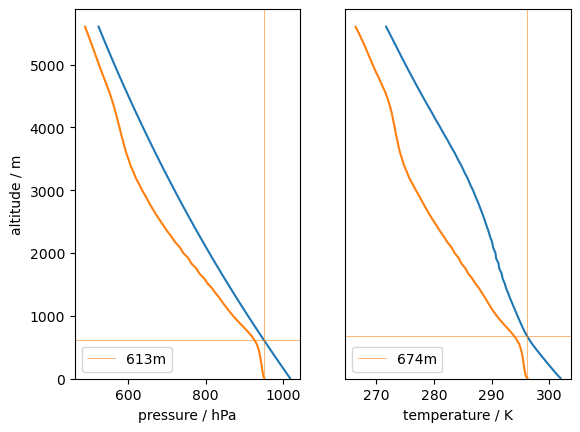

In [4]:
t = np.datetime64('2020-01-15T18:00:00.000000000')
data = load_data()
data = pp.remove_duplicates(data)
d = data.sel(time=t, method='nearest')

fig, axs = fig_lcl_and_profile(d)
fig.show()

In our plot above we show the LCL for each level, both isothermal lifting to a lower pressure level, or a isobaric lifting to a lower temperature level. As the potential temperature stays relatively constant throughout the well mixed surface layer, below the level where condensation starts, the LCL estimate does the same. The potential temperture also gives us an additional hint of the actual position of the LCL. Taking the isothermal LCL of a surface air parcel seems a reasonable approximation.

But this approach does not work well for the profiles in our control run:

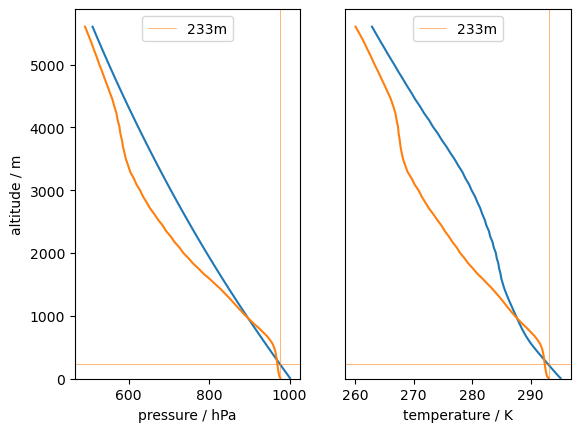

In [5]:
data = load_data(None)
d = data.sel(time=t, method='nearest')
t = d.time.values

fig, axs = fig_lcl_and_profile(d)
fig.show()

We are going to test a few more approaches of LCL calculation:

In [8]:
# LCL calculation functions from a script I got from Ann Kristin Naumann
# Authorship uncertain, possibly Theresa Lange
# ----------------------------------------------------------------------
# Useful functions to work with radiosonde data measured during EUREC4A 

import numpy as np
import typhon

def calc_lcl_simple(relative_humidity, altitude=0):
    """
    Calculates the Lifting Condensation Level (LCL) using a simple estimation method.

    This function estimates the LCL based on the surface relative humidity and altitude,
    using a rough rule of thumb that assumes a linear relationship between these variables
    and the LCL.

    Parameters:
    - relative_humidity (array-like): The relative humidity at the surface, expressed as a fraction (0 to 1).
    - altitude (array-like): The altitude of the observation point in meters.

    Returns:
    - float: The estimated LCL in meters.
    """
    lcl_simple = altitude[0] + (100 - relative_humidity[0] * 1e2) * 25
    return lcl_simple

def calc_lcl(temperature, relative_humidity, altitude=0, levels=0):
    """
    Calculates the Lifting Condensation Level (LCL) according to Bolton (1980).

    This method uses the temperature, relative humidity, and altitude at a specified level
    to calculate the LCL more accurately than the simple estimation. It applies the formula
    provided by Bolton (1980) to determine the altitude at which air becomes saturated when
    lifted adiabatically.

    Parameters:
    - temperature (array-like): The temperature in Kelvin at the specified level.
    - relative_humidity (array-like): The relative humidity as a fraction (0 to 1) at the specified level.
    - altitude (array-like): The altitude in meters at the specified level.
    - levels (int, optional): The index of the level at which to calculate the LCL. Defaults to 0 (surface level).

    Returns:
    - float: The calculated LCL in meters.
    """
    z0 = altitude[levels]
    cp = typhon.constants.isobaric_mass_heat_capacity
    g = typhon.constants.g
    tlcl = 1 / ((1 / (temperature[levels] - 55)) - (np.log(relative_humidity[levels]) / 2840.)) + 55
    zlcl = z0 - (cp * (tlcl - temperature[levels]) / g)
    mean_zlcl = np.mean(zlcl)
    
    return mean_zlcl

def calc_lcl_bco(temperature, dew_point, altitude=0, levels=0):
    """
    Calculates the Lifting Condensation Level (LCL) as used in the BCO (Barbados Cloud Observatory) quicklooks.

    This method provides an LCL calculation, using the temperature, dew point temperature, and altitude. 
    It assumes a linear relationship between the temperature-dew point spread and the altitude to estimate the LCL.

    Parameters:
    - temperature (array-like): The temperature in Kelvin at the specified level.
    - dew_point (array-like): The dew point temperature in Kelvin at the specified level.
    - altitude (array-like): The altitude in meters at the specified level.
    - levels (int, optional): The index of the level at which to calculate the LCL. Defaults to 0 (surface level).

    Returns:
    - float: The calculated LCL in meters.
    """
    zlcl = ((temperature[levels] - dew_point[levels]) / 8. + altitude[levels] / 1000.) * 1000.
    mean_zlcl = np.mean(zlcl)
    return mean_zlcl

This function calculates the LCL like we did before:

In [21]:
def calc_lcl_metpy(data):
    pressure          = d['pres'] * mpunit('Pa')
    temperature       = d['temp'] * mpunit('K')
    specific_humidity = d['qv']
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    LCL_pres, LCL_temp = metpy.calc.lcl(pressure, temperature, dewpoint)
    return {'pres':LCL_pres.magnitude.compute(), 'temp':LCL_temp.magnitude.compute()}

def calc_lcl_height_metpy(data):
    LCL = calc_lcl_metpy(data)
    for var in ['pres', 'temp']: 
        surface_value = LCL[var][-1]
        index = np.argmin(np.abs(data[var].values - surface_value))
        LCL[var] = data['height'].values[index] # replace values in dict with heights
    return LCL

And now we can compare the methods against each other:

In [19]:
from metpy.units import units as unit

def lcl_ensemble(data):
    '''Applies all the LCL functions for comparison'''
    # add units for the metpy part
    pressure          = data['pres'  ].values * unit(data['pres'  ].attrs['units'])
    temperature       = data['temp'  ].values * unit(data['temp'  ].attrs['units'])
    specific_humidity = data['qv'    ].values * unit(data['qv'    ].attrs['units'])
    altitude          = data['height'].values * unit(data['height'].attrs['units'])
    relative_humidity = metpy.calc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)
    dew_point         = metpy.calc.dewpoint_from_relative_humidity(temperature, relative_humidity)
    dew_point = dew_point.to('K')
    # put my thing down, flip it and reverse it
    pressure          = np.flip(pressure.magnitude)
    temperature       = np.flip(temperature.magnitude)
    specific_humidity = np.flip(specific_humidity.magnitude)
    relative_humidity = np.flip(relative_humidity.magnitude)
    dew_point         = np.flip(dew_point.magnitude)
    altitude          = np.flip(altitude.magnitude)
    # call the functions
    lcl_bco = calc_lcl_bco(temperature, dew_point, altitude , levels=0)
    lcl_rh  = calc_lcl(temperature, relative_humidity, altitude, levels=0)
    lcl_smp = calc_lcl_simple(relative_humidity, altitude)
    lcl_mp  = calc_lcl_height_metpy(data)
    lcl_mp_pres = lcl_mp['pres']
    lcl_mp_temp = lcl_mp['temp']
    return lcl_bco, lcl_rh, lcl_smp, lcl_mp_pres, lcl_mp_temp

In [20]:
t = np.datetime64('2020-01-15T18:00:00.000000000')

for data in [load_data(None), pp.remove_duplicates(load_data())]:
    d = data.sel(time=t, method='nearest')
    print(lcl_ensemble(d))

(216.40945434570312, 218.95102204862079, 251.25218391418457, 233.262939453125, 233.262939453125)
(588.8536071777344, 596.7489407319617, 607.836822271347, 613.2105102539062, 674.4213256835938)


So the LCL calculation methods do not differ substantially.

## Oversaturation

If we look at the LCL profile again we see that there is a part of the profile where the LCL temperature is higher than the environment temperature. This indicates oversaturation. Do we see oversaturation in the relative humidity profile, too? We do!:

In [36]:
import plot_utils as pu

vars = ['temp', 'qv', 'RH', 'theta', 'qc']
fig, axs = plt.subplots(1, len(vars), figsize=(20,10))
axs[2].axvline(1, color='black', alpha=.3)
for data, color in zip([load_data(None), pp.remove_duplicates(load_data())], ['black', 'tab:red']):
    d = data.sel(time=t, method='nearest')
    d = cc.add_relative_humidity(d)
    d = cc.add_prognostic_variables(d)
    y = d.height.values
    for var, ax in zip(vars, axs):
        x = d[var].values
        ax.plot(x,y, color=color)
        ax.set_xlabel(d[var].attrs['long_name'])
        ax.set_ylim(0,None)
for ax in axs[1::]: ax = pu.remove_ticks(ax, ['left','right'])

The data we look at has been averaged before the relative humidity has been calculated. So do we get oversaturation in single profiles, too? We do not:

In [1]:
import eurec4a
import metpy.units
import metpy.calc
import numpy as np
import matplotlib.pyplot as plt

def add_relative_humidity(dataset, varnames={'pressure':'pres', 'temperature':'temp', 'specific humidity':'qv', 'relative humidity':'RH'}):
    pressure          = dataset[varnames['pressure']].values          * metpy.units.units(dataset[varnames['pressure']].attrs['units'])
    temperature       = dataset[varnames['temperature']].values       * metpy.units.units(dataset[varnames['temperature']].attrs['units'])
    specific_humidity = dataset[varnames['specific humidity']].values * metpy.units.units(dataset[varnames['specific humidity']].attrs['units'])
    relative_humidity = metpy.calc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)
    dimnames = dataset[varnames['specific humidity']].dims
    dataset[varnames['relative humidity']] = (dimnames, relative_humidity.magnitude)
    attributes = {'long_name':'relative humidity', 'units':'1'}
    dataset[varnames['relative humidity']] = dataset[varnames['relative humidity']].assign_attrs(attributes)
    return dataset

def random_subsample(dataset, dim_samples):
    for dim, n_samples in dim_samples.items():
        if n_samples > dataset[dim].size:
            raise ValueError(f"n_samples ({n_samples}) for '{dim}' is greater than the size of the dimension ({dataset[dim].size}).")
        random_selection = np.random.choice(dataset[dim], size=n_samples, replace=False)
        dataset = dataset.sel({dim: random_selection})
    return dataset

data = eurec4a.get_intake_catalog()['simulations']['ICON']['LES_CampaignDomain_control']['3D_DOM01'].to_dask()
vars = ['temp', 'qv', 'RH', 'qc']
fig, axs = plt.subplots(1, len(vars), figsize=(20,10))

for t in range(100):
    d = random_subsample(data, {'time':1,'cell':1}).isel({'time':0, 'cell':0})
    d = add_relative_humidity(d)
    y = d.height.values
    for var, ax in zip(vars, axs):
        x = d[var].values
        ax.plot(x,y, color='black', lw=.2)
        ax.set_xlabel(d[var].attrs['long_name'])
        ax.set_ylim(y[-1],y[0])
for ax in axs[1::]: ax = ax.tick_params(left=0, right=0, labelleft=0)
axs[2].axvline(1, color='black') #, alpha=.3)

fig.show()

In conclusion we see that calculating relative humidity from averaged profiles can yield oversaturation. This is because the relationship between saturation vapor pressure and temperature is not linear.

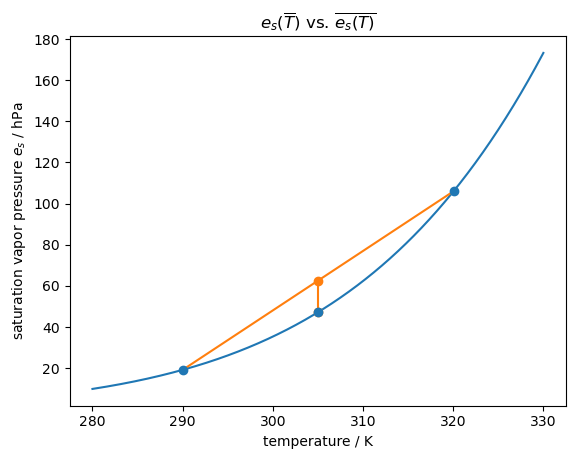

In [69]:
import metpy.calc
import metpy.units
import numpy as np
import matplotlib.pyplot as plt

temperature = np.linspace(280,330,1000) * metpy.units.units('K')
saturation_vapor_pressure = metpy.calc.saturation_vapor_pressure(temperature).to('hPa')

fig, ax = plt.subplots()
ax.plot(temperature, saturation_vapor_pressure)
selected_points = [200,800]
ax.plot(temperature[selected_points], saturation_vapor_pressure[selected_points], color='tab:orange')
ax.plot([temperature.magnitude[int(np.mean(selected_points))]] * 2, 
        [saturation_vapor_pressure.magnitude[int(np.mean(selected_points))], np.mean(saturation_vapor_pressure.magnitude[selected_points])], 
        color='tab:orange', zorder=10, marker='o') 
ax.scatter(temperature[selected_points+[int(np.mean(selected_points))]], 
           saturation_vapor_pressure[selected_points+[int(np.mean(selected_points))]], color='tab:blue', zorder=10)
ax.set_title(f'$e_s(\overline{{T}})$ vs. $\overline{{e_s(T)}}$')
ax.set_xlabel('temperature / K')
ax.set_ylabel(f'saturation vapor pressure $e_s$ / hPa')
fig.show()

We have a similar, less pronounced problem with potential temperature.

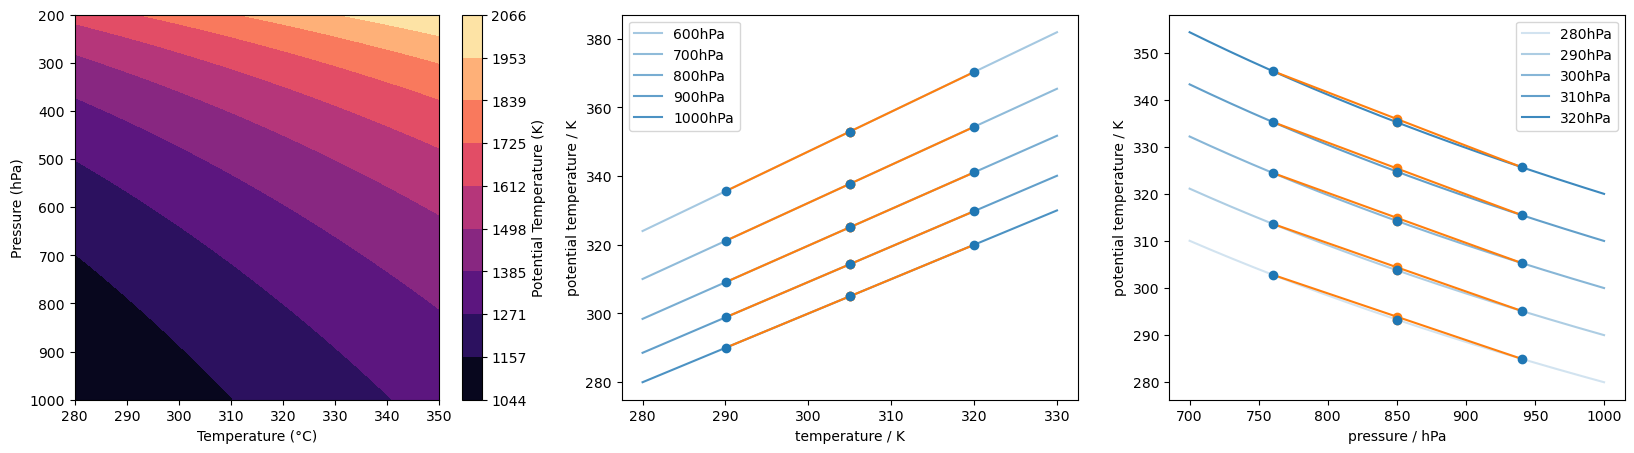

In [74]:
import metpy.calc
import metpy.units
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(20,5))

ax = axs[0]
temperature = np.linspace(280, 350, 100)
pressure = np.linspace(1000, 200, 100) 
T, P = np.meshgrid(temperature, pressure)
theta = metpy.calc.potential_temperature(P * metpy.units.units('pascal'), T * metpy.units.units('kelvin')).magnitude 
contour = ax.contourf(T, P, theta, levels=np.linspace(np.min(theta), np.max(theta), 10), cmap='magma')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Pressure (hPa)')
ax.invert_yaxis()
fig.colorbar(contour, ax=ax, label='Potential Temperature (K)')

ax = axs[1]
for pressure in [600, 700, 800, 900, 1000]:
    temperature = np.linspace(280,330,1000) * metpy.units.units('K')    
    pressure = pressure * metpy.units.units('hPa')
    potential_temperature = metpy.calc.potential_temperature(pressure, temperature)
    
    ax.plot(temperature, potential_temperature, color='tab:blue', label=f'{pressure.magnitude}hPa', alpha=(pressure.magnitude/1000 - .2))
    selected_points = [200,800]
    ax.plot(temperature[selected_points], potential_temperature[selected_points], color='tab:orange')
    ax.plot([temperature.magnitude[int(np.mean(selected_points))]] * 2, 
            [potential_temperature.magnitude[int(np.mean(selected_points))], np.mean(potential_temperature.magnitude[selected_points])], 
            color='tab:orange', zorder=10, marker='o') 
    ax.scatter(temperature[selected_points+[int(np.mean(selected_points))]], 
               potential_temperature[selected_points+[int(np.mean(selected_points))]], color='tab:blue', zorder=10)
ax.set_xlabel('temperature / K')
ax.set_ylabel('potential temperature / K')
ax.legend()

ax = axs[2]
for temperature in [280, 290, 300, 310, 320]:
    temperature = temperature * metpy.units.units('K')
    pressure = np.linspace(700,1000,1000) * metpy.units.units('hPa')    
    potential_temperature = metpy.calc.potential_temperature(pressure, temperature)
    ax.plot(pressure, potential_temperature, color='tab:blue', label=f'{temperature.magnitude}hPa', alpha=(0.2 + temperature.magnitude/60 - 280/60))
    selected_points = [200,800]
    ax.plot(pressure[selected_points], potential_temperature[selected_points], color='tab:orange')
    ax.plot([pressure.magnitude[int(np.mean(selected_points))]] * 2, 
            [potential_temperature.magnitude[int(np.mean(selected_points))], np.mean(potential_temperature.magnitude[selected_points])], 
            color='tab:orange', zorder=10, marker='o') 
    ax.scatter(pressure[selected_points+[int(np.mean(selected_points))]], 
               potential_temperature[selected_points+[int(np.mean(selected_points))]], color='tab:blue', zorder=10)
ax.set_xlabel('pressure / hPa')
ax.set_ylabel('potential temperature / K')

ax.legend()
fig.show()

## Unsorted scripts:
The rest of the notebook is a collection of unsorted LCL related scripts from other notebooks.

In [ ]:
stop() # stop executing the notebook here

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import postprocessing as pp
import xarray as xr
import matplotlib.pyplot as plt
import plot_utils as pu

data = xr.open_dataset('data/ctrl_prognostic_profiles.nc')
data = pp.replace_height_indices_with_values(data)
fig, ax = plt.subplots(figsize=(5,8))

for t in data.time.values:
    d = data['theta'].sel(time=t)
    x = d.values
    y = d.height.values
    ax.plot(x,y, color='black', alpha=0.02, lw=1)
    
d = data['theta'].mean(dim='time', keep_attrs=True)
x = d.values
y = d.height.values
ax.plot(x,y, color='red')

ax.set_ylabel('height / m')
ax.set_xlabel('potential temperature / K')
ax.set_ylim(0,None)
ax = pu.remove_spines(ax, ['top', 'right'])
fig.show()

### Histogram over domain mean time series

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

In [ ]:
import metpy.calc
import metpy.units
import numpy as np
    
def lcl_pres(data):    
    pressure          = d['pres'].load() * metpy.units.units('Pa')
    temperature       = d['temp'].load() * metpy.units.units('K')
    specific_humidity = d['qv'].load()
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    try:
        LCL_pres, _ = metpy.calc.lcl(pressure[-1], temperature[-1], dewpoint[-1], eps=1e-2)  # limiting the accuracy to 1% for efficiencies sake
        return LCL_pres.magnitude
    except ValueError:
        return np.nan

data = fh.eureca_data_from_keywords(['3D_DOM01'])
data = data.mean(dim='cell', keep_attrs=True)

lcl_array = list()
print(len(data.time.values), ':')
for i,t in enumerate(data.time.values):
    d = data.sel(time=t)
    lcl_array.append(lcl_pres(d))
    print(i,end=',')
print()

In [ ]:
import xarray as xr 

# lcl_values = ([np.ravel(e)[0] for e in lcl_array]
lcl_values = np.asarray([np.ravel(e)[0] for e in lcl_array])
lcl_da = xr.DataArray(lcl_values, coords=[data.time], dims=['time'], name='LCL_pres')
data['LCL_pres'] = lcl_da
lcl_da.to_netcdf('data/lcl_ctrl.nc')

In [ ]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=shared
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import metpy.calc
import metpy.units
import numpy as np
import os
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)
    
def lcl_pres(data):    
    pressure          = d['pres'].load() * metpy.units.units('Pa')
    temperature       = d['temp'].load() * metpy.units.units('K')
    specific_humidity = d['qv'].load()
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    try:
        LCL_pres, _ = metpy.calc.lcl(pressure[-1], temperature[-1], dewpoint[-1], eps=1e-2)  # limiti
        return LCL_pres.magnitude
    except ValueError:
        return np.nan

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/',
              file_slice=slice(50,53)):
    # kind = '3D'
    # data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'], return_file_list=1)
    # data = data[file_slice]

    # exp_dir   = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'
    
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = xr.open_mfdataset(file_list, chunks={}, combine='by_coords')
    # data = data.mean(dim='ncells', keep_attrs=True)
    # data = xr.open_mfdataset(data)
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data


print('loading data')
data = load_data()
lcl_array = list()
print('stepwise calculation')
print('')
for t in data.time.values:
    print(t,end=': ')
    try:
        d = data.sel(time=t)
        lcl_array.append(lcl_pres(d))
        print('SUCESS')
    except:
        lcl_array.append(np.nan)
        print('FAIL')
print('')

print('converting to xr.DataArray')
lcl_values = np.asarray([np.ravel(e)[0] for e in lcl_array])
lcl_da = xr.DataArray(lcl_values, coords=[load_data().time], dims=['time'], name='LCL_pres')
print('writing to netCDF')
try:
    save_directory = 'home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    lcl_da.to_netcdf(os.path.join(save_directory, 'lcl_warm.nc'))
except:
    print(f'failed. trying to save locally')
    lcl_da.to_netcdf('data_lcl_000001.nc')
print('DONE')

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

fig, ax = plt.subplots()
datasets = [xr.open_dataset('data/lcl_ctrl.nc'), xr.open_dataset('data/lcl_warm.nc')]
labels = ['ctrl', 'warm']
colors = ['black', 'tab:red']

for data, label, color in zip(datasets, labels, colors):
    data = data['LCL_pres'].values.flatten()  # Convert to a 1D NumPy array
    data = data[~np.isnan(data)]
    data = data / 100
    
    kde = scipy.stats.gaussian_kde(data)
    x_range = np.linspace(np.min(data), np.max(data), 1000)
    pdf_values = kde(x_range)
    plt.hist(data, bins=50, density=True, alpha=0.2, color=color)
    plt.plot(x_range, pdf_values, label=label, color=color)

ax.legend()
ax.set_title('LCL pressure')
ax.set_xlabel('Pressure / hPa')
ax.set_ylabel('Probability Density')
fig.show()

### domain mean LCL height timeseries netcdf 

In [ ]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('data/lcl_warm.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_height = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['LCL_pres'].values)
        val = d.height.values[index]
        lcl_height.append(val)
        print(f': SUCCESS', int(val))
    except:
        lcl_height.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_height])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='lcl_height')
lcl_height = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_height_warm.nc')
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_height_{timestamp()}_warm.nc'
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

In [ ]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    # file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    # for keyword in ['3D', 'DOM01']:
    #     file_list = [f for f in file_list if keyword in f]    
    # data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = pp.clean_volume_data(data)
    data = fh.eureca_data_from_keywords(['3D_DOM01'])
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_height = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['LCL_pres'].values)
        val = d.height.values[index]
        lcl_height.append(val)
        print(f': SUCCESS', int(val))
    except:
        lcl_height.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_height])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='lcl_height')
lcl_height = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_height_ctrl.nc')
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_height_{timestamp()}_ctrl.nc'
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

data = xr.merge([xr.open_dataset('data/lcl_height_ctrl.nc').expand_dims({'exp':['ctrl']}),
                 xr.open_dataset('data/lcl_height_warm.nc').expand_dims({'exp':['warm']})])

fig, ax = plt.subplots()
for exp, color in zip(data.exp.values, ['black', 'tab:red']):
    d = data.sel(exp=exp)
    x = d.time.values
    y = d['lcl_height'].values
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    ax.plot(x,y, color=color)
fig.show()

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import calculations as cc
fh.disable_warnings()

data = fh.eureca_data_from_keywords(['3D_DOM01'])

data = data.drop_vars([var for var in list(data) if var not in ['temp', 'pres', 'qv']])
data = data.mean(dim='cell')
data = cc.add_prognostic_variables(data)
data = data.mean(dim='cell')
data.to_netcdf('data/ctrl_prognostic_profiles.nc')

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import postprocessing as pp
import xarray as xr
import matplotlib.pyplot as plt
import plot_utils as pu

data = xr.open_dataset('data/ctrl_prognostic_profiles.nc')
data = pp.replace_height_indices_with_values(data)
fig, ax = plt.subplots(figsize=(5,8))

for t in data.time.values:
    d = data['theta'].sel(time=t)
    x = d.values
    y = d.height.values
    ax.plot(x,y, color='black', alpha=0.02, lw=1)
    
d = data['theta'].mean(dim='time', keep_attrs=True)
x = d.values
y = d.height.values
ax.plot(x,y, color='red')

ax.set_ylabel('height / m')
ax.set_xlabel('potential temperature / K')
ax.set_ylim(0,None)
ax = pu.remove_spines(ax, ['top', 'right'])
fig.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

data = xr.merge([
    xr.open_dataset('data/lcl_height_ctrl.nc').expand_dims({'exp':['ctrl']}),
    xr.open_dataset('data/lcl_height_warm.nc').expand_dims({'exp':['warm']})])

fig, ax = plt.subplots()
for exp, color in zip(data.exp.values, ['black', 'tab:red']):
    d = data.sel(exp=exp)['lcl_height']
    ax.hist(d, bins=10, color=color, alpha=0.4)
    ax.axvline(d.mean(dim='time'), color=color, label=f'mean of {exp}')
    
ax.set_title('Histogram of LCL heights')
ax.set_xlabel('LCL height / m')
ax.legend()
fig.show()

### The whole Theresa script
includes EIS and LTS functions. I added docstrings for some functions.

In [ ]:
# Useful functions to work with radiosonde data measured during EUREC4A 
# Authorship uncertain, possibly Theresa Lange

import numpy as np
from netCDF4 import Dataset
import glob
import xarray
import os
import matplotlib.pyplot as plt
import typhon
import copy
from scipy.interpolate import interp1d

def get_filenames(dates, start_time, end_time, platforms, branches, datapath):
    """
    Returns list of filenames of all available soundings for the specified days, time periods and platforms.
    """
    filenames = []
        
    for platform in platforms:
        if platform == 'ATL':
            time_ind = slice(-9, -5)
        else:
            time_ind = slice(-7, -3)
        for date in dates:
            if 'ascending' in branches:
                filenames_all = glob.glob(os.path.join(datapath, f'{platform}_SoundingAscentProfile_*_{date}_*.nc'))
                if filenames_all:
                    filenames_time = [f for f in filenames_all if int(f[time_ind]) > int(start_time) and int(f[time_ind]) < int(end_time)]
                    filenames.extend(filenames_time)
            if 'descending' in branches:
                filenames_all = glob.glob(os.path.join(datapath, f'{platform}_SoundingDescentProfile_*_{date}_*.nc'))
                if filenames_all:
                    filenames_time = [f for f in filenames_all if int(f[time_ind]) > int(start_time) and int(f[time_ind]) < int(end_time)]
                    filenames.extend(filenames_time)
    return filenames

def profiles_from_netcdf(path2file, variables):
    """
    Returns a dictionary with the specified variables for one sounding. 
    """
    profiles = {} 
    coords = ['pressure', 'latitude', 'longitude', 'flight_time']
    attrs = ['time_of_launch_HHmmss', 'date_YYYYMMDD', 'platform_name']
    filename = os.path.split(path2file)[1]
    platform = filename[0:3]
    va = variables.copy()
    ds = xarray.open_dataset(path2file)
    for variable in va:
        if variable in coords:
            profiles[variable] = ds.coords[variable].data[0]
        elif variable in attrs:
            profiles[variable] = ds.attrs[variable]
        else:
            profiles[variable] = ds.variables[variable].data[0]
    return profiles

def interpolate_profiles(profiles, variables, height):
    """
    Returns a dictionary containing the specified variables, interpolated to a given height vector. 
    """
    profiles_interp = copy.deepcopy(profiles)
    for i, profile in enumerate(profiles):
        for var in variables:
            var_interp = interp1d(profile['altitude'], profile[var], fill_value='extrapolate', bounds_error=False)(height)
            profiles_interp[i][var] = var_interp
        profiles_interp[i]['altitude'] = height
    
    return profiles_interp

def calc_potential_temperature(temperature, pressure):
    """
    Returns potential temperature [K].
    """
    R = typhon.constants.gas_constant_dry_air
    cp = typhon.constants.isobaric_mass_heat_capacity
    exponent = R / cp
    pot_temp = temperature * (1e5 / pressure) ** exponent
    
    return pot_temp

def calc_virtual_potential_temperature(temperature, mixing_ratio, pressure):
    """
    Returns virtual potential temperature [K]
    """
    potential_temp = calc_potential_temperature(temperature, pressure)
    virtual_potential_temp = potential_temp * (1 + 0.61 * mixing_ratio)
    
    return virtual_potential_temp

def calc_lower_tropospheric_stability(temperature, pressure):
    """
    Returns lower tropospheric stability (LTS) [K] calculated following Wood and Hartmann (2006).
    """
    if pressure[-1] < pressure[0]:
        surf_ind = 0
    else:
        surf_ind = -1
        
    potential_temperature = calc_potential_temperature(temperature, pressure)
    pot_temp_interp = interp1d(pressure, potential_temperature, fill_value='extrapolate', bounds_error=False)
    lts = pot_temp_interp(700e2) - potential_temperature[surf_ind]
    return lts

def calc_integrated_water_vapor(vmr, temperature, pressure, altitude):
    """
    Returns integrated water vapour [kg/m**-3]
    """
    nan_mask = np.isnan(vmr) + np.isnan(temperature) + np.isnan(pressure) + np.isnan(altitude)
    nan_ind = np.where(~nan_mask)
    
    if pressure[-1] > pressure[0]:
        vmr = np.flipud(vmr[nan_ind])
        temp = np.flipud(temperature[nan_ind])
        pres = np.flipud(pressure[nan_ind])
        alt = np.flipud(altitude[nan_ind])
    else:
        vmr = vmr[nan_ind]
        temp = temperature[nan_ind]
        pres = pressure[nan_ind]
        alt = altitude[nan_ind]
    
    iwv = typhon.physics.atmosphere.integrate_water_vapor(
        vmr=vmr, 
        p=pres, 
        T=temp, 
        z=alt
    )
    
    return iwv

def calc_precipitable_water(vmr, temperature, pressure, altitude):
    """
    Returns precipitable water [mm]
    """
    water_density = 997
    iwv = calc_integrated_water_vapor(vmr, temperature, pressure, altitude)
    pw = iwv / water_density * 1e3
    
    return pw

def calc_lcl_simple(relative_humidity, altitude=0):
    """
    Calculates the Lifting Condensation Level (LCL) using a simple estimation method.

    This function estimates the LCL based on the surface relative humidity and altitude,
    using a rough rule of thumb that assumes a linear relationship between these variables
    and the LCL.

    Parameters:
    - relative_humidity (array-like): The relative humidity at the surface, expressed as a fraction (0 to 1).
    - altitude (array-like): The altitude of the observation point in meters.

    Returns:
    - float: The estimated LCL in meters.

    Example:
    >>> calc_lcl_simple(relative_humidity=[0.7], altitude=[100])
    1750.0
    """
    lcl_simple = altitude[0] + (100 - relative_humidity[0] * 1e2) * 25
    return lcl_simple

def calc_lcl(temperature, relative_humidity, altitude=0, levels=0):
    """
    Calculates the Lifting Condensation Level (LCL) according to Bolton (1980).

    This method uses the temperature, relative humidity, and altitude at a specified level
    to calculate the LCL more accurately than the simple estimation. It applies the formula
    provided by Bolton (1980) to determine the altitude at which air becomes saturated when
    lifted adiabatically.

    Parameters:
    - temperature (array-like): The temperature in Kelvin at the specified level.
    - relative_humidity (array-like): The relative humidity as a fraction (0 to 1) at the specified level.
    - altitude (array-like): The altitude in meters at the specified level.
    - levels (int, optional): The index of the level at which to calculate the LCL. Defaults to 0 (surface level).

    Returns:
    - float: The calculated LCL in meters.

    Example:
    >>> calc_lcl(temperature=[300], relative_humidity=[0.5], altitude=[1000])
    925.0
    """
    z0 = altitude[levels]
    cp = typhon.constants.isobaric_mass_heat_capacity
    g = typhon.constants.g
    tlcl = 1 / ((1 / (temperature[levels] - 55)) - (np.log(relative_humidity[levels]) / 2840.)) + 55
    zlcl = z0 - (cp * (tlcl - temperature[levels]) / g)
    mean_zlcl = np.mean(zlcl)
    
    return mean_zlcl

def calc_lcl_bco(temperature, dew_point, altitude=0, levels=0):
    """
    Calculates the Lifting Condensation Level (LCL) as used in the BCO (Barbados Cloud Observatory) quicklooks.

    This method provides an LCL calculation specific to the BCO quicklook methodology, using
    the temperature, dew point temperature, and altitude. It assumes a linear relationship
    between the temperature-dew point spread and the altitude to estimate the LCL.

    Parameters:
    - temperature (array-like): The temperature in Kelvin at the specified level.
    - dew_point (array-like): The dew point temperature in Kelvin at the specified level.
    - altitude (array-like): The altitude in meters at the specified level.
    - levels (int, optional): The index of the level at which to calculate the LCL. Defaults to 0 (surface level).

    Returns:
    - float: The calculated LCL in meters.

    Example:
    >>> calc_lcl_bco(temperature=[300], dew_point=[290], altitude=[1000])
    2250.0
    """
    zlcl = ((temperature[levels] - dew_point[levels]) / 8. + altitude[levels] / 1000.) * 1000.
    mean_zlcl = np.mean(zlcl)
    return mean_zlcl

def calc_eis(pressure, temperature, relative_humidity, altitude):
    """
    Returns estimated inversion strength (EIS) [K] calculated according to Wood and Bretherton (2006).
    """
    moist_lapse_rate = typhon.physics.moist_lapse_rate(pressure, temperature)
    moist_lapse_rate_850hPa = interp1d(pressure, moist_lapse_rate)(850e2)
    
    lts = calc_lower_tropospheric_stability(temperature, pressure)
    lcl = calc_lcl(temperature, relative_humidity, altitude)
    z700hPa = interp1d(pressure, altitude)(700e2)
    eis = lts - moist_lapse_rate_850hPa * (z700hPa - lcl)
    
    return eis

def get_inversion_props(temperature, mixing_ratio, pressure, height, min_pres=700e2, virtual=True):
    """
    Returns inversion height defined as the maximum in the vertical gradient of virtual 
    potential temprature.
    """
    if virtual:
        potential_temperature = calc_virtual_potential_temperature(temperature, mixing_ratio, pressure)
    else:
        potential_temperature = calc_potential_temperature(temperature, pressure)
    # smooth curves
    gradient_pot_temp = np.diff(potential_temperature) / np.diff(height)
    gradient_pot_temp = np.append(gradient_pot_temp, gradient_pot_temp[-1])
    lower_tropo = np.logical_and(pressure > min_pres, pressure < 1000e2)
    inversion_ind = np.argmax(gradient_pot_temp[lower_tropo])
    inversion_height = height[lower_tropo][inversion_ind]
    
    return inversion_height, gradient_pot_temp

def smooth_profiles(profiles, variables, n_smooth):
    """ 
    Returns dictionary containing smoothed profiles of specified variables.
    """
    
    profiles_smoothed = copy.deepcopy(profiles)
    for i, profile in enumerate(profiles):
        for var in variables:
            var_smoothed = smooth_profile(profile[var], n_smooth)
            profiles_smoothed[i][var] = var_smoothed
    return profiles_smoothed
    
def smooth_profile(profile, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(profile, box, mode='valid')
    return y_smooth

def calc_mean_profiles(profiles, heights, variables):
    """ Returns mean profiles of specified variables from different soundings.
    Only works with profiles that are already interpolated to a common vertical grid.
    """
    mean_profiles = {}
    for var in variables:
        var_arr = np.zeros((len(profiles), len(heights)))
        for i in range(len(profiles)):
            var_arr[i] = profiles[i][var]
        var_mean = np.mean(var_arr, axis=0)
        mean_profiles[var] = var_mean
    return mean_profiles
    
def layer_mean_speed(wind_speed, altitude, z):
    """
    Returns mean over layer 250 m around given height 
    over given list of regridded wind profiles.
    """
    layer_ind = np.logical_and(altitude > z - 125, altitude < z + 150)
    layer_depth = np.diff(altitude)
    wind_speed_mean = np.sum(wind_speed[layer_ind] * layer_depth[layer_ind[:-1]]) / np.sum(layer_depth[layer_ind[:-1]])
    
    return wind_speed_mean

def layer_mean_dir(wind_direction, wind_speed, altitude, z):
    """
    Returns mean over layer 250 m around given height 
    """
    u, v = calc_wind_components(wind_direction, wind_speed)
    layer_ind = np.logical_and(altitude > z - 125, altitude < z + 150)
    layer_depth = np.diff(altitude)
    u_mean = np.sum(u[layer_ind] * layer_depth[layer_ind[:-1]]) / np.sum(layer_depth[layer_ind[:-1]])
    v_mean = np.sum(v[layer_ind] * layer_depth[layer_ind[:-1]]) / np.sum(layer_depth[layer_ind[:-1]])
    
    return calc_wind_direction(u_mean, v_mean)

def calc_wind_components(wind_direction, wind_speed):
    """ 
    Returns wind components U and V.
    """
    u = -np.sin(wind_direction * np.pi / 180.) * wind_speed
    v = -np.cos(wind_direction * np.pi / 180.) * wind_speed
    
    return u, v

def calc_wind_direction(u, v):
    """ Returns wind direction.
    """
    direction = (180. + np.arctan2(u, v) * 180. / np.pi)
    return direction

def calc_wind_speed(u, v):
    """ Returns wind speed.
    """
    speed = np.sqrt(u**2 + v**2)
    return speed